<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/UV_Measurement_to_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hier werden die Rohdaten des BTS2048-UV-WP in eine nutzbare CSV-Datei geschrieben

Dokumentenname: UV_Measurement_to_CSV.ipynb




Es werden die OR0-Daten (NasaAmes-Format), die eigentlich für den Versand an das BFS gedacht sind umgewandelt und in eine CSV-Datei geschrieben. Aufgrund der großen Datenmenge geschieht dies für jeden Monat getrennt.

In [1]:
# Import der benötigten Module
import os, sys
import glob
import datetime
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt

from scipy.io import netcdf
from datetime import timedelta
from datetime import datetime

from google.colab import drive
from google.colab import files

**Monat der Exportiert werden soll:**

In [2]:
month = '22.09'

Zu Beginn muss die Google-Drive eingerichtet werden, in der die Messdaten (OR0-Dateien) gespeichert sind. Danach werden alle verfügbaren Unterordner aufgerufen. So wird geprüft, ob der Mount richtig funktioniert hat.

In [3]:
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive'
# Durchsuche den Google Drive-Pfad
for root, dirs, files in os.walk(drive_path):
    for dir in dirs:
        # Gib den Namen des Unterordners aus
        print(os.path.join(root, dir))

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab_Notebooks/CSV_Messdaten
/content/drive/MyDrive/Colab_Notebooks/NasaAmes_Messdaten
/content/drive/MyDrive/Colab_Notebooks/CSV_UVI
/content/drive/MyDrive/Colab_Notebooks/CSV_Gewichtet
/content/drive/MyDrive/Colab_Notebooks/CSV_SolarRadiation
/content/drive/MyDrive/Colab_Notebooks/netCDF4_Wetterdaten
/content/drive/MyDrive/Colab_Notebooks/CAMS_Vorhersage
/content/drive/MyDrive/Colab_Notebooks/Clean_Data
/content/drive/MyDrive/Colab_Notebooks/plot_daily_UVI
/content/drive/MyDrive/Colab_Notebooks/SOLYS_Messdaten
/content/drive/MyDrive/Colab_Notebooks/NasaAmes_Messdaten/Data
/content/drive/MyDrive/Colab_Notebooks/NasaAmes_Messdaten/Data/22.07
/content/drive/MyDrive/Colab_Notebooks/NasaAmes_Messdaten/Data/22.08
/content/drive/MyDrive/Colab_Notebooks/NasaAmes_Messdaten/Data/22.09
/content/drive/MyDrive/Colab_Notebooks/NasaAmes_Messdaten/Data/22.10
/content/drive/

Danach werden die einzelnen OR0-Dateien (NasaAmes Format) geladen und umgewandelt.

Das NasaAmes Format: https://espoarchive.nasa.gov/content/Ames_Format_Specification_v20

Die Messdaten sind unter dem FFI (File Format Index) 2005 gespeichert. Dieser Standard ist durch die Nasa nicht dokumentiert. Deshalb nachfolgend ein eigener Parser, der die Daten in eine nutzbare CSV umwandelt.

**Beschreibung der einzelnen Dictionaries und deren Inhalt:**

- **file_names** = enthält die Dateinamen der einzelnen OR0-Dateien
- **file_content** = Enthält den Inhalt der OR0-Dateien
- **end_line_header** = enthält die Zeile an dem der Header endet

**Dateien einlesen:**

In [4]:
# Pfad zum Ordner mit den Dateien in Google Drive
folder_path = '/content/drive/MyDrive/Colab_Notebooks/NasaAmes_Messdaten/Data/' + month

# OR0-Dateien im Ordner lesen
file_paths = glob.glob(folder_path + '/*.OR0')

# Liste für die Dateinamen erstellen
file_names = []

# Schleife über die Dateien
for file_path in file_paths:

    if os.path.getsize(file_path) > 100 * 1024:
      # Dateiname extrahieren
      file_name = os.path.splitext(os.path.basename(file_path))[0]

      # Datei öffnen und Inhalt lesen
      with open(file_path, 'r') as file:
          file_content = file.read()

      # Variable für die Datei erstellen
      globals()[file_name] = file_content

      file_names.append(file_name)

**Dataframe mit Wellenlängen erstellen:**
- Dieser wird später genutzt um die Spalten des Dataframe zu benennen.

In [5]:
def create_df_Wellenlaenge(start, end, step):
    # Erstelle eine Liste mit den gewünschten Werten
    numbers_list = [round(num, 3) for num in list(np.arange(start, end + step, step))]
    # Erstelle den Dataframe
    df = pd.DataFrame({'Wellenlaenge': numbers_list})

    return df

In [6]:
np_Wellenlaenge = np.round(np.arange(290.0, 420.05, 0.1), decimals = 1)
df_Wellenlaenge = pd.DataFrame({'Wellenlaenge': np_Wellenlaenge})

**String aufteilen in einzelne Zeile schreiben:**

- Zur weitern Verarbeitung müssen alle Elemente als einzelene Strings abgespeichet werden.

In [7]:
file_content = {}  # Dictionary für die Messungen erstellen

for file_name in file_names:
    file_variables = globals()[file_name]
    file_content[file_name] = file_variables

# Auf Variablen zugreifen und String in Zeilen aufteilen
for file_name, variable in file_content.items():
    file_content[file_name] = file_content[file_name].split('\n')

**Header extrahieren:**

In [8]:
# Funktion um den Dateiheader zu extrahieren
def perform_action(file_variables, file_names):
    header_dict = {file_name: "" for file_name in file_names}
    end_line_header_fnc = 0

    for file_name, data in file_variables.items():
        for i, line in enumerate(data):
            header_dict[file_name] += line + "\n"
            if line.strip() == "Pyranometer: readout interval [secs]=5":
                end_line_header_fnc = i
                break

    return header_dict, end_line_header_fnc

In [9]:
file_header, end_line_header = perform_action(file_content, file_names)

**Header aus Datensatz löschen:**

In [10]:
def remove_header(lines_content, end_line):
    lines_WO_header_fnc = {}
    lines_WO_header_fnc = lines_content.copy()

    for key, value in lines_WO_header_fnc.items():
        del value[:end_line+1]

    return lines_WO_header_fnc

In [11]:
lines_WO_header = remove_header(file_content, end_line_header)

**Elemente aufteilen:**

In [12]:
def flatten_and_split(input_list):
    result = []
    for sublist in input_list:
        elements = sublist.split()
        result.extend(elements)
    return result

In [13]:
def process_dict(input_dict):
    processed_dict = {}
    for key, value in input_dict.items():
        processed_value = flatten_and_split(value)
        sublists = []
        sublist = []
        for element in processed_value:
            if element.isdigit() and len(element) == 5:
                if sublist:
                    sublists.append(sublist)
                    sublist = []
            sublist.append(element)
        if sublist:
            sublists.append(sublist)
        processed_dict[key] = sublists
    return processed_dict

In [14]:
processed_dict = process_dict(lines_WO_header)

**Zeitstempel in Datensatz finden:**

In [15]:
# Funktion zum finden eines 5 stelligen Integers (= Zeitstempel)
def find_5_digit_integers(input_list):
    result = []
    for sublist in input_list:
        for element in sublist:
            if isinstance(element, str) and element.isdigit() and len(element) == 5:
                result.append(element)
    return result

In [16]:
# Funktion, die durch das dict iterriert
def find_5_digit_integers_in_dict(input_dict):
    result_dict = {}
    for key, value in input_dict.items():
        result_dict[key] = find_5_digit_integers(value)
    return result_dict

In [17]:
result_dict = find_5_digit_integers_in_dict(processed_dict)

**Dict in Dataframe speichern:**

In [18]:
# Erstelle eine leere Liste, um die Zeilen für den DataFrame aufzunehmen
data_rows = []
df_Messdaten = []

# Iteriere durch das verschachtelte Dictionary und erstelle Zeilen für den DataFrame
for key, value in processed_dict.items():
    for sublist in value:
        data_rows.append([key] + sublist)

# Definiere Spaltennamen für den DataFrame
columns = ['Datum'] + [f'Wert{i}' for i in range(1, len(data_rows[0]))]

# Erstelle den Pandas DataFrame
df_rows = pd.DataFrame(data_rows, columns=columns)
df_Messdaten = df_rows

**Prüfen, ob der Inhalt des DF korrekt ist:**

In [19]:
df_rows

,Datum,Wert1,Wert2,Wert3,Wert4,Wert5,Wert6,Wert7,Wert8,Wert9,...,Wert1309,Wert1310,Wert1311,Wert1312,Wert1313,Wert1314,Wert1315,Wert1316,Wert1317,Wert1318
0,SA220906,16320,97,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,7.8661E-04,7.7102E-04,7.7257E-04,7.7377E-04,7.7653E-04,7.8976E-04,5.1281E-04,0.0000E+00,0.0000E+00,0.0000E+00
1,SA220906,16440,95,-6.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,1.1227E-03,1.1170E-03,1.1140E-03,1.0805E-03,1.0680E-03,1.0401E-03,1.0363E-03,1.0408E-03,1.0423E-03,1.0564E-03
2,SA220906,16560,95,-6.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,1.5345E-03,1.5176E-03,1.4873E-03,1.4577E-03,1.4299E-03,1.4139E-03,1.4246E-03,1.4172E-03,1.4134E-03,1.4313E-03
3,SA220906,16680,80,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,2.0209E-03,1.9990E-03,1.9614E-03,1.9108E-03,1.8568E-03,1.8448E-03,1.8441E-03,1.8296E-03,1.8533E-03,1.8479E-03
4,SA220906,16800,65,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,2.5355E-03,2.5455E-03,2.5154E-03,2.4803E-03,2.4475E-03,2.3887E-03,2.3293E-03,2.3383E-03,2.3774E-03,2.3850E-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8254,SA220901,59400,66,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,2.7140E-01,2.7109E-01,2.6810E-01,2.6345E-01,2.5861E-01,2.5476E-01,2.5227E-01,2.5079E-01,2.5025E-01,2.5176E-01
8255,SA220901,59520,63,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,2.6426E-01,2.6422E-01,2.6067E-01,2.5452E-01,2.5061E-01,2.4746E-01,2.4503E-01,2.4379E-01,2.4375E-01,2.4554E-01
8256,SA220901,59640,111,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,2.5048E-01,2.4962E-01,2.4697E-01,2.4124E-01,2.3864E-01,2.3564E-01,2.3276E-01,2.3154E-01,2.3206E-01,2.3369E-01
8257,SA220901,59760,78,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,2.4472E-01,2.4430E-01,2.4125E-01,2.3657E-01,2.3358E-01,2.3066E-01,2.2762E-01,2.2667E-01,2.2782E-01,2.2902E-01


**Konvertieren des DF:**

In [20]:
# Bestimme die Indexposition, ab der die neuen Spaltennamen zugewiesen werden sollen
start_index = 18  # Beispiel: Beginne ab der dritten Spalte

# Extrahiere die neuen Spaltennamen aus dem zweiten DataFrame
new_column_names = df_Wellenlaenge['Wellenlaenge'].tolist()

# Ändere die Spaltennamen des DataFrames ab der angegebenen Indexposition
for i, new_name in enumerate(new_column_names):
    df_Messdaten.columns.values[start_index + i] = new_name

In [21]:
# Funktion zum Konvertieren des Datumsformats
def convert_date_format(date_str):
    date_str = date_str[2:]  # Entferne das "SA"-Präfix
    date_obj = datetime.strptime(date_str, "%y%m%d")
    return date_obj

In [22]:
# Wende die Funktion auf die Spalte an
df_Messdaten['Datum'] = df_Messdaten['Datum'].apply(convert_date_format)

In [23]:
spalten_zum_loeschen = df_Messdaten.columns[2:18]  # Index 3 bis Index 19
df_Messdaten.drop(spalten_zum_loeschen, axis=1, inplace=True)

In [24]:
# Splaten umbennen und ordnen
spalte_uhrzeit = pd.to_datetime(df_Messdaten['Wert1'], unit='s').dt.time

position = 1
df_Messdaten.insert(position, 'Uhrzeit', spalte_uhrzeit)

spaltenname = 'Messzeitpunkt'
df_Messdaten.rename(columns={'Wert1': spaltenname}, inplace=True)

df_Messdaten.insert(0, 'Datetime', df_Messdaten['Datum'] + pd.to_timedelta(df_Messdaten['Uhrzeit'].astype(str)))

In [25]:
# Splaten in float umwandeln
df_Messdaten[np_Wellenlaenge] = df_Messdaten[np_Wellenlaenge].astype(float)

In [26]:
print(df_Messdaten)

                Datetime      Datum   Uhrzeit Messzeitpunkt  290.0  290.1  \
0    2022-09-06 04:32:00 2022-09-06  04:32:00         16320    NaN    NaN   
1    2022-09-06 04:34:00 2022-09-06  04:34:00         16440    NaN    NaN   
2    2022-09-06 04:36:00 2022-09-06  04:36:00         16560    NaN    NaN   
3    2022-09-06 04:38:00 2022-09-06  04:38:00         16680    NaN    NaN   
4    2022-09-06 04:40:00 2022-09-06  04:40:00         16800    NaN    NaN   
...                  ...        ...       ...           ...    ...    ...   
8254 2022-09-01 16:30:00 2022-09-01  16:30:00         59400    NaN    NaN   
8255 2022-09-01 16:32:00 2022-09-01  16:32:00         59520    NaN    NaN   
8256 2022-09-01 16:34:00 2022-09-01  16:34:00         59640    NaN    NaN   
8257 2022-09-01 16:36:00 2022-09-01  16:36:00         59760    NaN    NaN   
8258 2022-09-01 16:38:00 2022-09-01  16:38:00         59880    NaN    NaN   

      290.2  290.3  290.4  290.5  ...  419.1  419.2  419.3  419.4  419.5  \

In [27]:
def save_dataframe_to_drive(dataframe, folder_path, filename):

    # Erstelle den vollen Pfad zur Datei
    full_path = os.path.join(folder_path, filename)

    # Speichere den DataFrame als CSV-Datei auf Google Drive
    dataframe.to_csv(full_path, index=False)

    print(f'Der DataFrame wurde als {filename} in {folder_path} auf Google Drive gespeichert.')

In [28]:
save_dataframe_to_drive(df_Messdaten, '/content/drive/My Drive/Colab_Notebooks/CSV_Messdaten', month)

Der DataFrame wurde als 22.09 in /content/drive/My Drive/Colab_Notebooks/CSV_Messdaten auf Google Drive gespeichert.


**Allgemeine Informationen über den Dataframe:**

In [29]:
def finde_max_werte_fuer_alle_spalten(df):
    # Erstellt ein Dictionary, um die maximalen Werte jeder Spalte zu speichern
    max_werte = {}
    id_werte = {}
    # Iteriere über alle Spalten im DataFrame
    for spalte in df.columns:
        # Ignoriere nicht-numerische Spalten
        if pd.api.types.is_numeric_dtype(df[spalte]):
            max_werte[spalte] = df[spalte].max()      # Maximaler Wert
            id_werte[spalte] = df[spalte].idxmax()    # Spalte mit dem höchsten Wert
    return max_werte, id_werte

In [30]:
# Funktion um den Maximalen Eintrag einer Spalte zu finden
max_werte, id_werte = finde_max_werte_fuer_alle_spalten(df_Messdaten[np_Wellenlaenge])

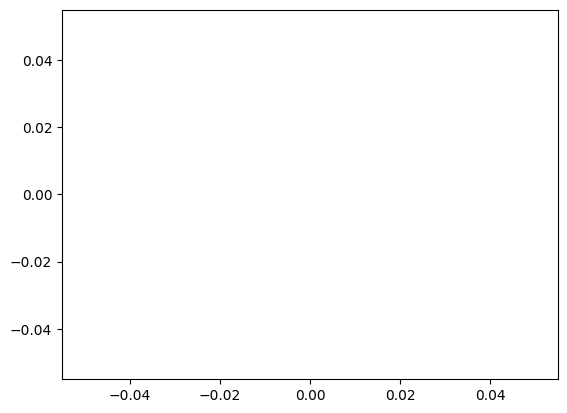

In [31]:
# Plotten der maximalen Werte nach Wellenlänge
schluessel_max = list(max_werte.keys())
werte_max = list(max_werte.values())
plt.plot(schluessel_max, werte_max)

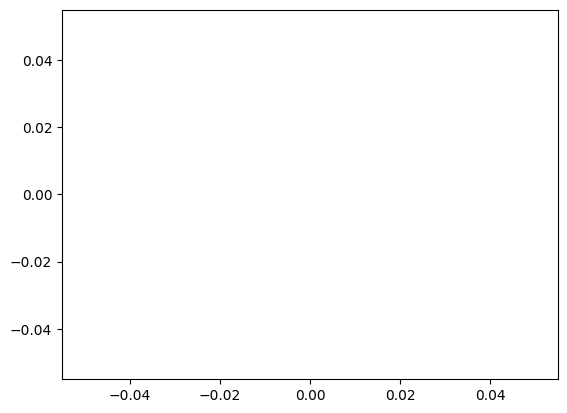

In [32]:
max_werte_rows, id_werte_rows = finde_max_werte_fuer_alle_spalten(df_rows[np_Wellenlaenge])

schluessel_max = list(max_werte_rows.keys())      # Spalte mit dem maximalen Eintrag
werte_max = list(max_werte_rows.values())         # Maximaler Wert
plt.plot(schluessel_max, werte_max)               # Plotten der maximalen Werte über den jeweiligen Wellenlängen

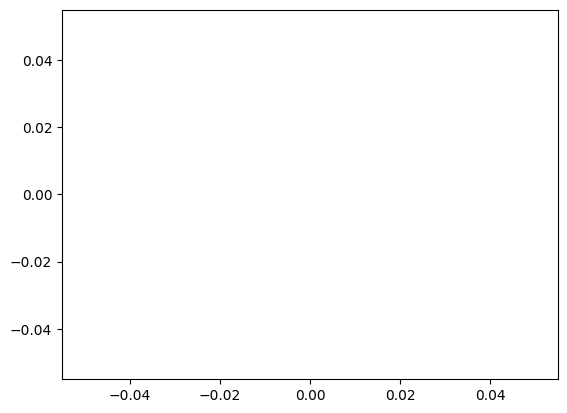

In [33]:
#
schluessel_id = list(id_werte.keys())
werte_id = list(id_werte.values())
plt.plot(schluessel_id, werte_id)

In [48]:
threshold = 0.000002
selected_rows = df_Messdaten[df_Messdaten.iloc[:, 18:1305].gt(threshold).any(axis=1)]

In [49]:
selected_rows

,Datetime,Datum,Uhrzeit,Messzeitpunkt,290.0,290.1,290.2,290.3,290.4,290.5,...,419.1,419.2,419.3,419.4,419.5,419.6,419.7,419.8,419.9,420.0


am 01.09 und 02.09 gibt es fehlerhafte Einträge. Diese am besten händisch korregieren.